# **Business Use Case 4**

# Clustering based on similar spending behaviors using K-Modes and Hamming Distance

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. Import Packages

In [ ]:
!pip install -r https://raw.githubusercontent.com/phuonganh-38/transaction-analysis-ML/main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [ ]:
!pip install kmodes

In [ ]:
import csv
import os
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.   Load Dataset

In [ ]:
#Merge all transactions
data_folder = '/content/drive/My Drive/Transaction Analysis - ML/Transactions'

data = []

for file_csv in os.listdir(data_folder):
    if file_csv.endswith('.csv'):
        file_path = os.path.join(data_folder, file_csv)
        features = pd.read_csv(file_path, sep='|')
        data.append(features)

transactions = pd.concat(data, ignore_index=True)
print(transactions)

                   cc_num      acct_num                         trans_num  \
0           4218196001337  888022315787  91ab12e73ef38206e1121e9648d2408d   
1           4218196001337  888022315787  071553d533a6822a4431c354c434ddcb   
2           4218196001337  888022315787  0cfad38ef15e4749eff68dc83f62c151   
3           4218196001337  888022315787  5782693d7c70f062f258cb30bfa8900f   
4           4218196001337  888022315787  35fd7db657d7e30dd608c37f7798186e   
...                   ...           ...                               ...   
4260899  4413395479406453  929002904576  660c294fe8d540431cc54d25077dc4d1   
4260900  4413395479406453  929002904576  4be02c8434ff59abf1d72f2b8372be0f   
4260901  4413395479406453  929002904576  0b9f714b93b5b1369cdd4fbbc111297d   
4260902  4413395479406453  929002904576  db1d2149e9c939413b0a33b672b496f2   
4260903  4413395479406453  929002904576  fa5d1154d8add5ac13931ab0008df642   

          unix_time       category    amt is_fraud        merchant  merch_l

In [ ]:
#Load customers dataset
# Define the function to separate values into columns
def separate_values(file_path):
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='|')
        columns = next(reader)  # Get the column names from the first row
        data = list(reader)     # Get the remaining rows as data

    return columns, data

# File URL
file_url = '/content/drive/My Drive/Transaction Analysis - ML/customers.csv'

# Call the function to separate values into columns
columns, data = separate_values(file_url)

# Convert data into a DataFrame
customers = pd.DataFrame(data, columns=columns)
customers

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.268,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,392-96-7670,30125158904184,Sarah,Martin,F,1666 Jenna Unions,Denver,CO,80236,39.6535,-105.0376,990452,Colour technologist,1993-08-31,201218361926
996,594-17-7993,180047909863618,Erin,Wells,F,444 Alexis Estate Suite 824,Wasco,CA,93280,35.648,-119.4487,27152,Software engineer,1982-05-27,921460407733
997,196-93-1156,4371450311809,Michael,James,M,914 Cassandra Gateway Suite 061,Escondido,CA,92026,33.1605,-117.0978,171802,Agricultural consultant,1999-05-14,499348764671
998,895-65-9304,3519925692476886,Michael,Lewis,M,34141 Katelyn Path,Mattapan,MA,2126,42.2739,-71.0939,25562,Civil Service administrator,1994-02-23,617852071065


In [ ]:
# Remove spaces from 'cc_num' and 'acct_num' column
transactions['cc_num'] = transactions['cc_num'].replace(' ', '')
customers['cc_num'] = customers['cc_num'].replace(' ', '')
transactions['acct_num'] = transactions['acct_num'].replace(' ', '')
customers['acct_num'] = customers['acct_num'].replace(' ', '')

#Astype 'cc_num' and 'acct_num'
transactions['cc_num'] = transactions['cc_num'].astype(float)
transactions['acct_num'] = transactions['acct_num'].astype(float)
customers['cc_num'] = customers['cc_num'].astype(float)
customers['acct_num'] = customers['acct_num'].astype(float)

In [ ]:
#Merge dataset
df = transactions.merge(customers, how='left', on=['cc_num', 'acct_num'])
df

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,...,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4.218196e+12,8.880223e+11,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4.218196e+12,8.880223e+11,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
2,4.218196e+12,8.880223e+11,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
3,4.218196e+12,8.880223e+11,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
4,4.218196e+12,8.880223e+11,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434,...,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,4.413395e+15,9.290029e+11,660c294fe8d540431cc54d25077dc4d1,1670377413,kids_pets,2.89,0,Morris-Tran,34.687688,-118.891984,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260900,4.413395e+15,9.290029e+11,4be02c8434ff59abf1d72f2b8372be0f,1664342570,home,9.63,0,Lopez PLC,34.381254,-117.017665,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260901,4.413395e+15,9.290029e+11,0b9f714b93b5b1369cdd4fbbc111297d,1672056151,travel,1.78,0,Sanchez Ltd,33.151970,-118.836058,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19
4260902,4.413395e+15,9.290029e+11,db1d2149e9c939413b0a33b672b496f2,1668741851,kids_pets,8.18,0,Garcia PLC,33.925622,-118.417269,...,F,790 Sharp Crossing Apt. 898,West Covina,CA,91791,34.0653,-117.8978,108175,Occupational therapist,1966-06-19


### 2. Explore Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 23 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      float64
 1   acct_num    float64
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
 10  ssn         object 
 11  first       object 
 12  last        object 
 13  gender      object 
 14  street      object 
 15  city        object 
 16  state       object 
 17  zip         object 
 18  lat         object 
 19  long        object 
 20  city_pop    object 
 21  job         object 
 22  dob         object 
dtypes: float64(5), object(18)
memory usage: 747.7+ MB


In [ ]:
df.describe()

,cc_num,acct_num,amt,merch_lat,merch_long
count,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06,4.260904e+06
mean,3.916811e+17,4.913599e+11,6.898790e+01,3.735276e+01,-9.247610e+01
std,1.267805e+18,2.897749e+11,1.618467e+02,5.504630e+00,1.741603e+01
min,6.040027e+10,2.348758e+09,1.000000e+00,1.859001e+01,-1.603677e+02
25%,1.800618e+14,2.568452e+11,9.100000e+00,3.370138e+01,-9.903072e+01
50%,3.524238e+15,4.719310e+11,4.449000e+01,3.819365e+01,-8.727445e+01
75%,4.604409e+15,7.518511e+11,8.158000e+01,4.120567e+01,-7.966098e+01
max,4.986227e+18,9.993899e+11,4.130053e+04,6.577610e+01,-6.724632e+01


In [ ]:
df.shape

(4260904, 23)

### 3. Data pre-processing

In [ ]:
#Convert unix timestamp to datetime
df['transaction time'] = pd.to_datetime(df['unix_time'], unit='s')

#Extract year_month of transaction
df['trans_year_month'] = df['transaction time'].dt.to_period('M')

In [ ]:
#Rename columns
df=df.rename(columns={'cc_num':'credit card number',
                      'acct_num':'account number',
                'trans_num': 'transaction number',
                  'amt': 'amount',
                  'merch_lat': 'merchant lattitude',
                  'merch_long': 'merchant longitude',
                  'city_pop': 'population of city',
                  'zip': 'zipcode',
                  'lat': 'transaction lattitude',
                  'long': 'transaction longitude'})

In [ ]:
#Create a new column 'card_holder' by concatenating 'first' and 'last' names
df['card holder'] = df['first'] + ' ' + df['last']

#Drop columns
df.drop(['first', 'last'], axis=1, inplace=True)

In [ ]:
#Calculate cardholders age
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (2024  - df['dob'].dt.year)

In [ ]:
print(df['age'].min())
print(df['age'].max())

17
97


In [ ]:
#Divide ages into 4 age groups
for i in range(len(data)):
    if((df['age'] <= 24).empty):
        df.iloc[i,100] = '17-24'
    elif(df['age'].between(25, 44).empty):
         df.iloc[i,100] = '25-44'
    elif(df['age'].between(45, 69).empty):
         df.iloc[i,100] = '45-69'
    elif((df['age'] >= 70).empty):
         df.iloc[i,100] = '70+'

conditions = [
    (df['age'] <= 24),
    (df['age'].between(25, 44)),
    (df['age'].between(45, 69)),
    (df['age'] >= 70)]
choices = ['17-24', '25-44', '45-69', '70+']
df['age group'] = np.select(conditions, choices, default='')

In [ ]:
#Define desired column order
order = ['card holder', 'credit card number', 'account number', 'dob', 'age', 'age group',
         'gender', 'job', 'ssn', 'street', 'zipcode', 'city', 'state',
         'transaction lattitude', 'transaction longitude', 'population of city',
         'transaction number', 'transaction time', 'trans_year_month','category', 'amount','merchant',
         'merchant lattitude', 'merchant longitude', 'is_fraud']

#Reindex the DataFrame with the desired column order
df=df.reindex(columns=order)

In [ ]:
#Drop unnecessary columns
df = df.drop(columns=['ssn', 'transaction lattitude', 'gender', 'transaction longitude', 'merchant lattitude',
       'merchant longitude', 'transaction time'])
df

,card holder,credit card number,account number,dob,age,age group,job,street,zipcode,city,state,population of city,transaction number,trans_year_month,category,amount,merchant,is_fraud
0,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,91ab12e73ef38206e1121e9648d2408d,2019-05,gas_transport,69.12,Phillips Group,0
1,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,071553d533a6822a4431c354c434ddcb,2019-09,grocery_pos,68.11,Tucker Ltd,0
2,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,0cfad38ef15e4749eff68dc83f62c151,2019-12,misc_net,40.35,Dixon PLC,0
3,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,5782693d7c70f062f258cb30bfa8900f,2019-10,grocery_pos,96.22,Lambert-Cooper,0
4,Jonathan Johnson,4.218196e+12,8.880223e+11,1959-10-03,65,45-69,Accounting technician,863 Lawrence Valleys,19002,Ambler,PA,32412,35fd7db657d7e30dd608c37f7798186e,2019-02,gas_transport,71.89,Griffith LLC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4260899,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,660c294fe8d540431cc54d25077dc4d1,2022-12,kids_pets,2.89,Morris-Tran,0
4260900,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,4be02c8434ff59abf1d72f2b8372be0f,2022-09,home,9.63,Lopez PLC,0
4260901,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,0b9f714b93b5b1369cdd4fbbc111297d,2022-12,travel,1.78,Sanchez Ltd,0
4260902,Cindy Frazier,4.413395e+15,9.290029e+11,1966-06-19,58,45-69,Occupational therapist,790 Sharp Crossing Apt. 898,91791,West Covina,CA,108175,db1d2149e9c939413b0a33b672b496f2,2022-11,kids_pets,8.18,Garcia PLC,0


### 4. Explore Target variable

In [ ]:
df.groupby('is_fraud')['is_fraud'].count()

,is_fraud
is_fraud,
0,4255870
1,5034


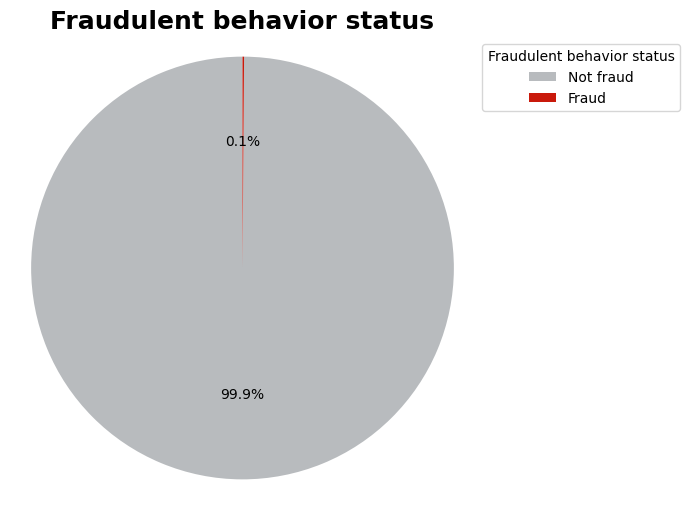

In [ ]:
plt.figure(figsize=(6,6))

#Chart colors
colors = ['#B8BBBE', '#C9190B']

#Count the occurences of each category
counts = df['is_fraud'].value_counts()

#Plot bar chart
plt.pie(counts, colors=colors, autopct='%1.1f%%', startangle=90)

#Add labels and title
plt.title('Fraudulent behavior status', fontsize=18, weight='bold')
plt.axis('equal')
plt.legend(['Not fraud', 'Fraud'], title='Fraudulent behavior status', loc="upper left", bbox_to_anchor=(1, 1))

plt.show()

- There is a total of 4,261,904 transactions. In which, there are 4,255,870 valid transactions (99.9%), and 5,034 fraud cases (0.1%).
- The dataset is highly imbalanced.

### 5. Explore Variables of Interest

### Fraudulent transactions by categories

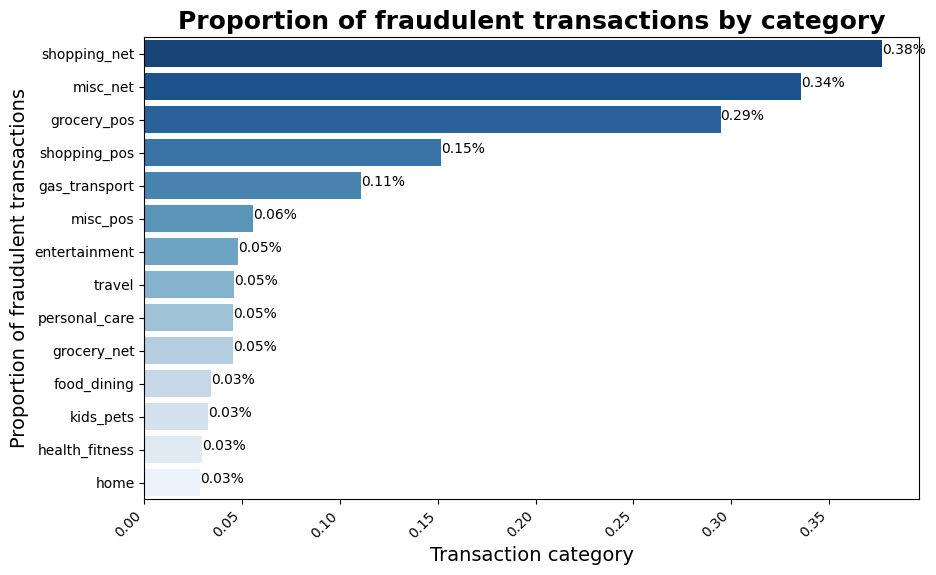

Top 5 categories with the highest occurrence of fraudulent transactions:
category
shopping_net     0.377183
misc_net         0.335616
grocery_pos      0.294514
shopping_pos     0.151570
gas_transport    0.110614
Name: count, dtype: float64


In [ ]:
fraudulent_transactions = df[df['is_fraud'] == 1]

#Count total number of transactions by category
category_counts = df['category'].value_counts()

#Count number of fraudulent transactions by category
fraud_counts = fraudulent_transactions['category'].value_counts()

#Fraud proportion
fraud_proportion = ((fraud_counts/category_counts)*100).sort_values(ascending=False)

#Visualisation
plt.figure(figsize=(10,6))
sns.barplot(x=fraud_proportion.values, y=fraud_proportion.index, palette="Blues_r")
plt.xlabel('Transaction category', fontsize = 14)
plt.ylabel('Proportion of fraudulent transactions', fontsize = 14)
plt.title('Proportion of fraudulent transactions by category', fontsize = 18, weight = 'bold')
plt.xticks(rotation=45, ha='right')

y=fraud_proportion.values
for index, value in enumerate(y):
    plt.text(value, index, str(round(value,2))+'%')
plt.show()

top_categories = fraud_proportion.head(5)
print("Top 5 categories with the highest occurrence of fraudulent transactions:")
print(top_categories)

### Fraudulent transactions by jobs

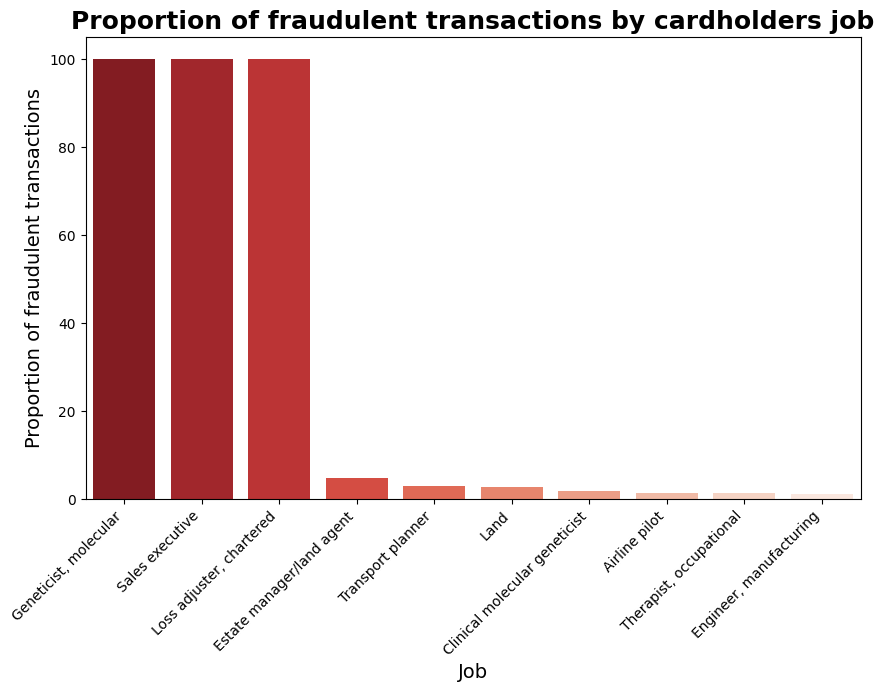

Top 5 jobs with the highest occurrence of fraudulent transactions: 

Geneticist, molecular: 100.00%
Sales executive: 100.00%
Loss adjuster, chartered: 100.00%
Estate manager/land agent: 4.79%
Transport planner: 2.98%


In [ ]:
fraudulent_transactions = df[df['is_fraud'] == 1]

#Count total number of transactions by job
job_counts = df['job'].value_counts()

#Count number of fraudulent transactions by job
fraud_counts = fraudulent_transactions['job'].value_counts()

#Fraud proportion
fraud_proportion = ((fraud_counts/job_counts)*100).sort_values(ascending=False)

# Top 10 jobs with highest fraud proportion
top_10_jobs = fraud_proportion.head(10)

#Visualisation
plt.figure(figsize=(10,6))
sns.barplot(y=top_10_jobs.values, x=top_10_jobs.index, palette="Reds_r")
plt.xlabel('Job', fontsize = 14)
plt.ylabel('Proportion of fraudulent transactions', fontsize = 14)
plt.title('Proportion of fraudulent transactions by cardholders job', fontsize = 18, weight = 'bold')
plt.xticks(rotation=45, ha='right')

plt.show()

print("Top 5 jobs with the highest occurrence of fraudulent transactions: \n")
for job, proportion in fraud_proportion.head(5).items():
    print(f"{job}: {proportion:.2f}%")

### Fraudulent transactions by months

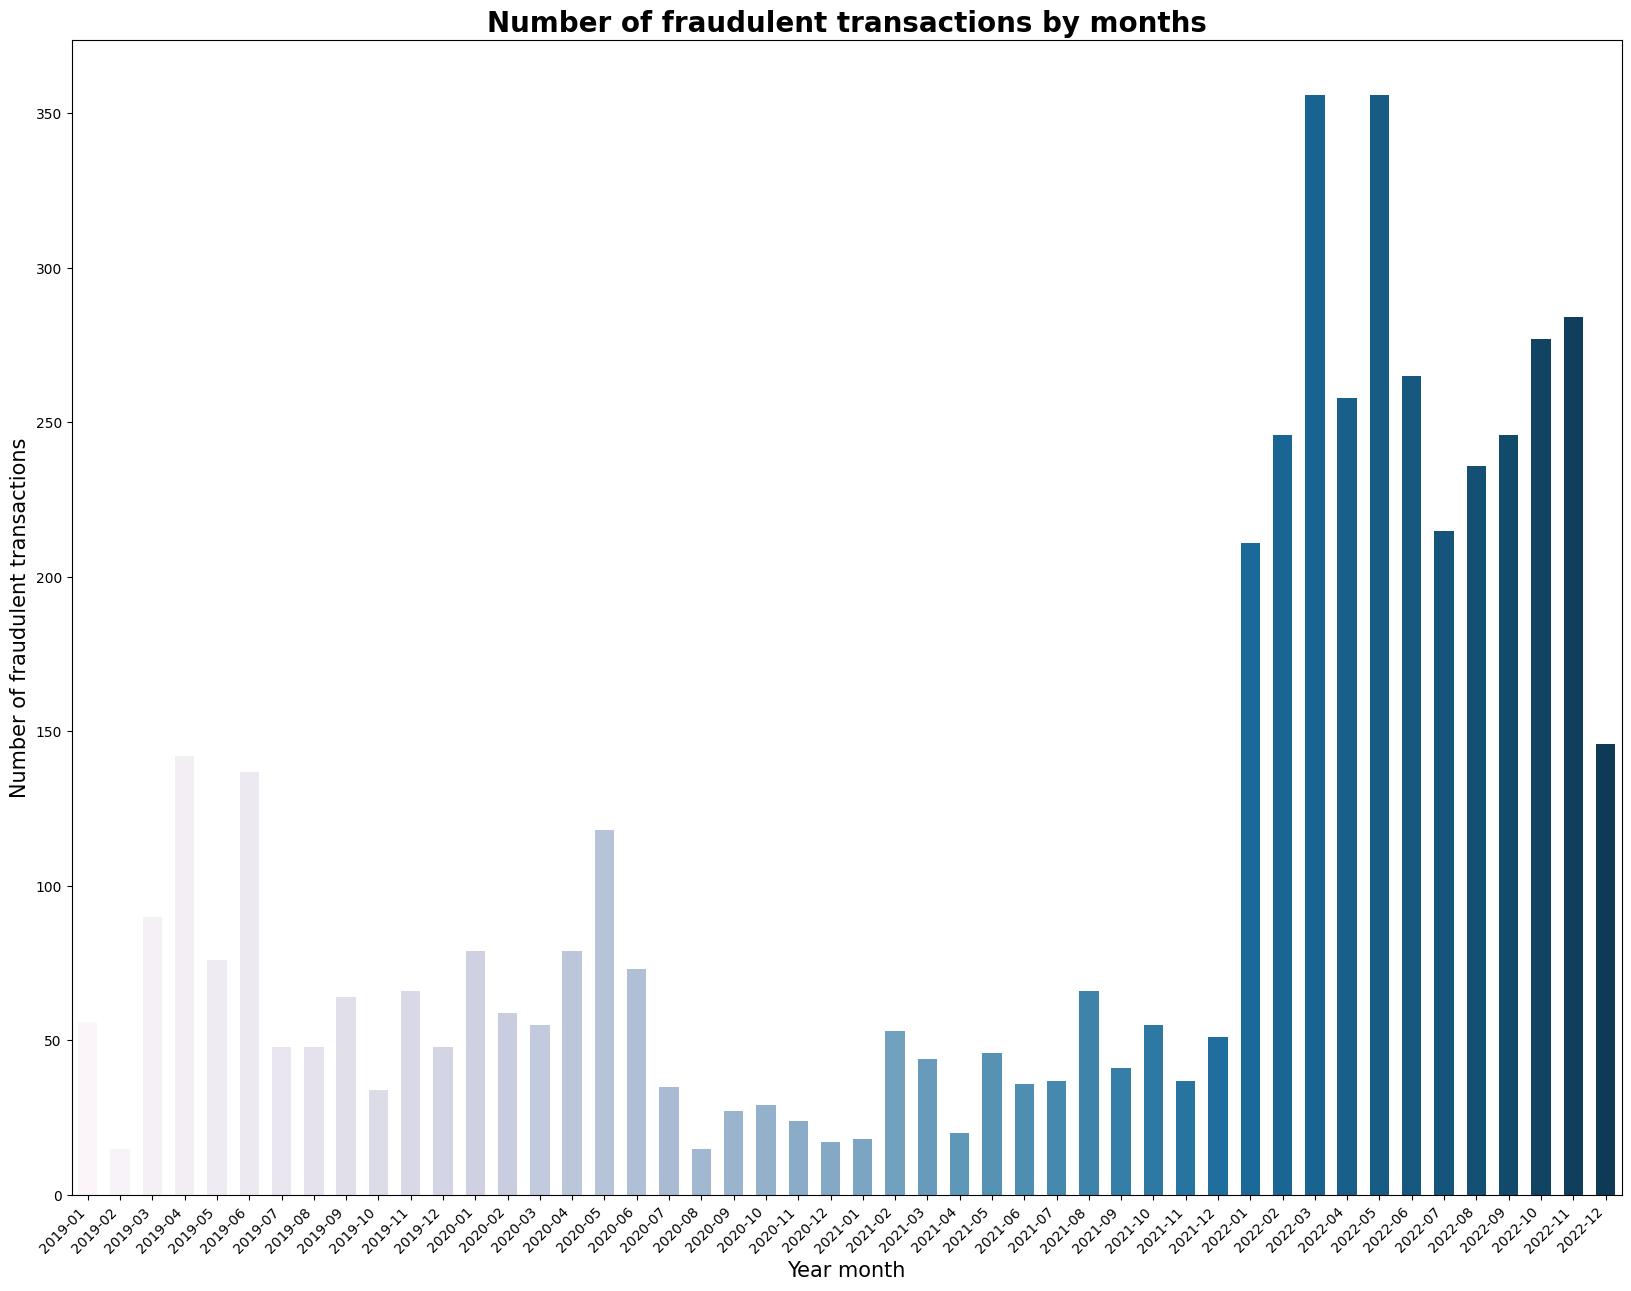

In [ ]:
fraudulent_transactions = df[df['is_fraud'] == 1]
frauds_by_year_month = fraudulent_transactions['trans_year_month']

# Sort
frauds_by_year_month_sorted = frauds_by_year_month.sort_values()

# Visualisation
plt.figure(figsize=(20,15))
sns.countplot(x=frauds_by_year_month_sorted, order=frauds_by_year_month_sorted.unique(), palette = 'PuBu',  width=0.6)
plt.xlabel('Year month', fontsize = 15)
plt.ylabel('Number of fraudulent transactions', fontsize = 15)
plt.title('Number of fraudulent transactions by months', fontsize = 20, weight = 'bold')
plt.xticks(rotation=45, ha='right')
plt.show()

March 2022 and May 2022 are months with the highest number of fraud transactions

### Fraudulent transactions by age group

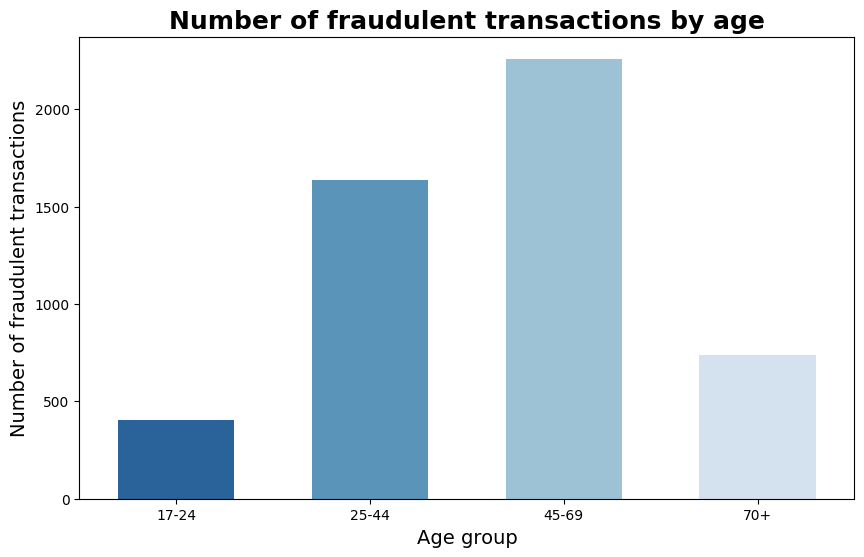

In [ ]:
fraudulent_transactions = df[df['is_fraud'] == 1]

# Count the number of fraudulent transactions by age
frauds_by_age = fraudulent_transactions['age group'].value_counts()


# Visualization
plt.figure(figsize=(10,6))
order = ['17-24', '25-44', '45-69', '70+']
sns.countplot(x=fraudulent_transactions['age group'], order=order, palette='Blues_r', width=0.6)
plt.xlabel('Age group', fontsize=14)
plt.ylabel('Number of fraudulent transactions', fontsize=14)
plt.title('Number of fraudulent transactions by age', fontsize=18, weight='bold')
plt.show()

### Fraudulent transactions by state

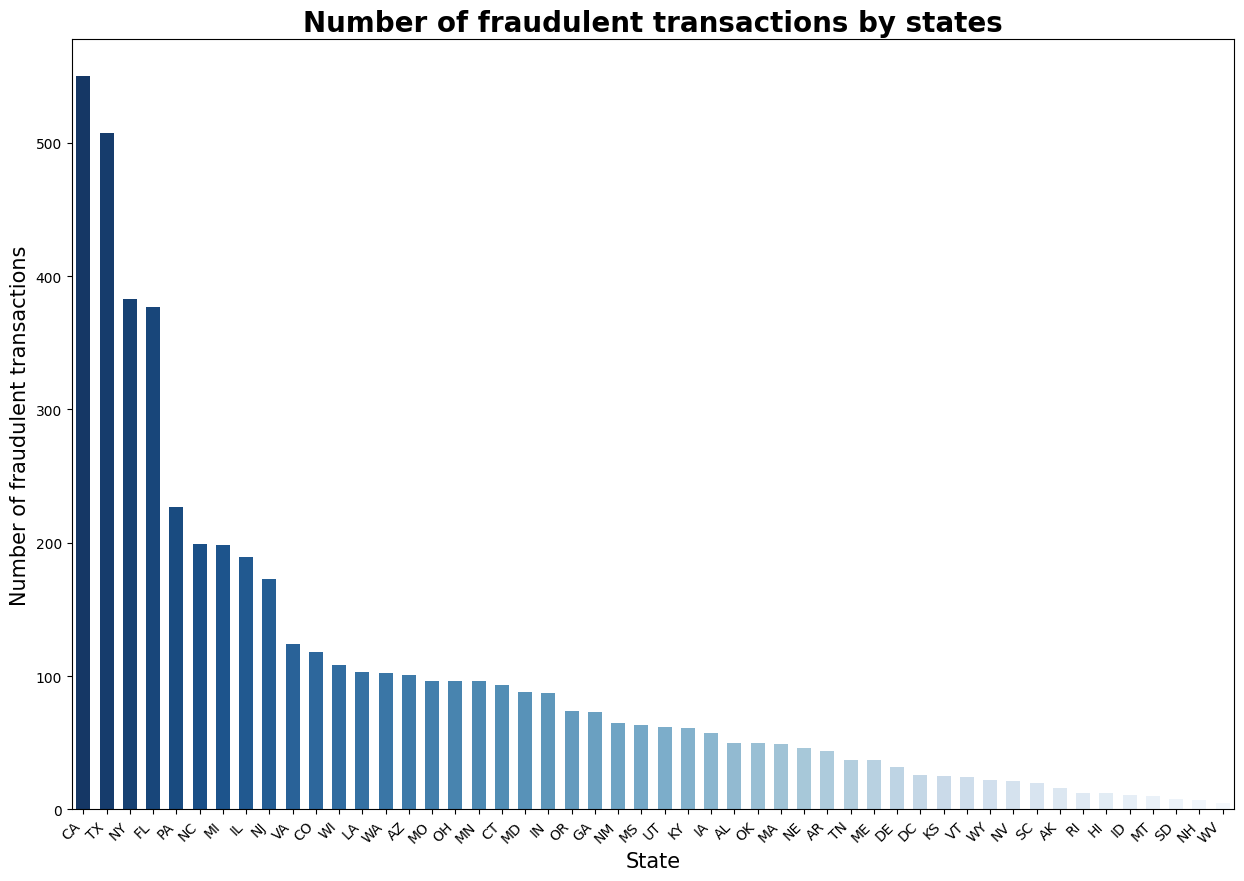

In [ ]:
fraudulent_transactions = df[df['is_fraud'] == 1]

# Count the number of fraudulent transactions by state
frauds_by_state = fraudulent_transactions['state'].value_counts()

# Sort states by the number of fraudulent transactions in descending order
frauds_by_state_sorted = frauds_by_state.sort_values(ascending=False)

# Visualization
plt.figure(figsize=(15,10))
sns.countplot(x=fraudulent_transactions['state'], palette='Blues_r', order=frauds_by_state_sorted.index, width=0.6)
plt.xlabel('State', fontsize=15)
plt.ylabel('Number of fraudulent transactions', fontsize=15)
plt.title('Number of fraudulent transactions by states', fontsize=20, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

### 6. Data processing

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
card holder,0
credit card number,0
account number,0
dob,0
age,0
age group,0
job,0
street,0
zipcode,0
city,0


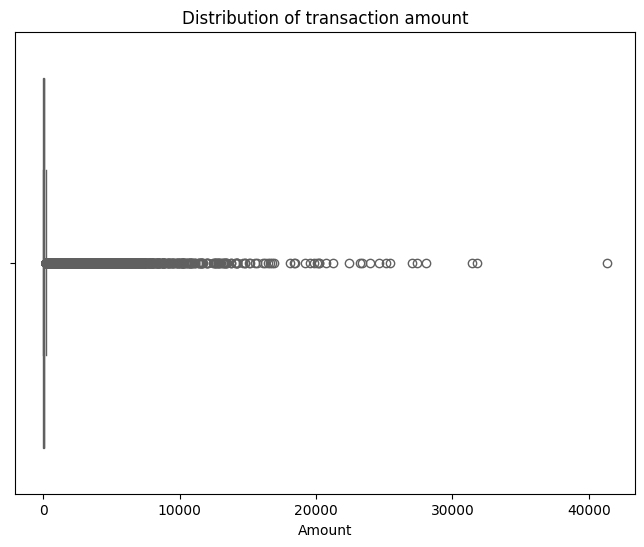

In [ ]:
#Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='amount', palette='Blues')
plt.title('Distribution of transaction amount')
plt.xlabel('Amount')
plt.show()

# Use case 4: Send customized marketing emails to groups of customers presenting similar spending behaviors (clustering)


Demographic Features:

1. Age Group: Age group can provide insights into how spending behaviors vary across different age demographics. We will be using age group instead of age as our segmentation goal is to identify broad age segments (e.g., young adults, middle-aged, seniors) and understand how spending behaviors differ between these groups.

2. Job: Occupation can influence spending habits and preferences.

Transactional Features:

1. Category: The category of transactions (e.g., groceries, entertainment, travel) can reveal spending patterns and preferences.


2. Amount: The transaction amount directly reflects spending behavior and can be a crucial feature for segmentation.

3. Merchant: Different merchants may attract different customer segments, so including merchant information can help identify spending preferences.

In [ ]:
# Manually label encoding age groups

# Define mapping dictionary
age_group_mapping = {
    '17-24': 1,
    '25-44': 2,
    '45-69': 3,
    '70+': 4
}

# Apply label encoding using map function
df['age group'] = df['age group'].map(age_group_mapping)


In [ ]:
df['age group'].unique()

array([3, 4, 1, 2])

In [ ]:
# Exploring the 'job' feature: unique values
print(df['job'].unique())

# Counting unique job categories
print(df['job'].nunique())

['Accounting technician' 'Seismic interpreter'
 'Programme researcher, broadcasting/film/video' 'Insurance risk surveyor'
 'Solicitor' 'Therapist, speech and language' 'Pathologist'
 'Energy engineer' 'Call centre manager' 'Associate Professor'
 'Buyer, retail' 'Early years teacher' 'Petroleum engineer'
 'IT sales professional' 'Engineer, mining' 'Surveyor, quantity'
 'Psychologist, counselling' 'Research scientist (maths)' 'IT consultant'
 'Senior tax professional/tax inspector' 'Engineer, civil (contracting)'
 'Sports development officer' 'Acupuncturist' 'Horticultural therapist'
 'Sports coach' 'Designer, exhibition/display' 'Paediatric nurse'
 'Research officer, government' 'Interior and spatial designer'
 'Social research officer, government' 'Architectural technologist'
 'Programmer, systems' 'Statistician' 'Chief Financial Officer'
 'Local government officer' 'Forensic psychologist'
 'Diplomatic Services operational officer' 'Teacher, early years/pre'
 'Engineer, aeronautical' '

In [ ]:
# Exploring the 'category' feature: unique values
print(df['category'].unique())

# Counting unique categories
print(df['category'].nunique())

['gas_transport' 'grocery_pos' 'misc_net' 'misc_pos' 'entertainment'
 'food_dining' 'shopping_pos' 'shopping_net' 'grocery_net' 'personal_care'
 'health_fitness' 'travel' 'home' 'kids_pets']
14


In [ ]:
# Exploring the 'merchant' feature: unique values
print(df['merchant'].unique())

# Counting unique merchant categories
print(df['merchant'].nunique())

['Phillips Group' 'Tucker Ltd' 'Dixon PLC' ... 'Garcia-Anthony'
 'Carlson, Young and Gallegos' 'Vega, Wright and Jones']
21977


In [ ]:
# Select only the specified features
features_to_keep = ['age group', 'job', 'category', 'merchant', 'amount']
df_selected = df[features_to_keep]

K-Modes clustering is specifically designed to work with categorical data. K-Modes extends the concept of K-Means clustering to handle categorical variables by using a matching dissimilarity measure rather than Euclidean distance.

In K-Modes clustering:

* The dissimilarity between two data points is calculated based on the number of mismatches in their categorical values.
* It aims to minimize the total dissimilarity within clusters, similar to K-Means, but it operates on categorical variables.

Except 'amount', all other relevant features are categorical. Now we will convert 'amount' to 3 bins- low, medium and high.

In [ ]:
# Convert 'amount' to categorical bins using quartiles
df_selected['amount_bin'] = pd.qcut(df_selected['amount'], q=3, labels=['low', 'medium', 'high'])

# Drop the original numerical 'amount' column
df_selected.drop(columns=['amount'], inplace=True)


<ipython-input-37-648a7b4c14e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['amount_bin'] = pd.qcut(df_selected['amount'], q=3, labels=['low', 'medium', 'high'])
<ipython-input-37-648a7b4c14e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.drop(columns=['amount'], inplace=True)


In [ ]:
# Checking whether the 3 bins have similar distribution of records
df_selected['amount_bin'].value_counts()

,count
amount_bin,
low,1420541
medium,1420247
high,1420116


### Elbow method for optimal number of clusters (k)

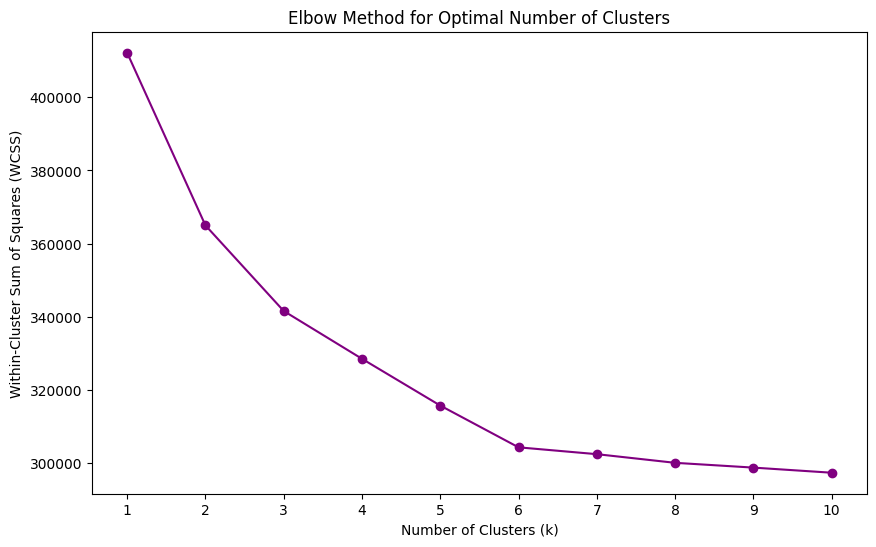

In [ ]:
# Sample a subset of data
sample_size = 100000
df_sampled = df_selected.sample(n=sample_size, random_state=42)

# Initialize a list to store the within-cluster sum of squares (WCSS) for different k values
wcss = []

# Define range of k values to try
k_values = range(1, 11)  # Try k from 1 to 10 clusters

# Calculate WCSS for each k value
for k in k_values:
    km = KModes(n_clusters=k, init='Cao', verbose=0)
    km.fit(df_sampled)
    wcss.append(km.cost_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='purple')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.show()


k=6 is selected as the optimal number of clusters, as adding more clusters beyond this point does not significantly decrease WCSS.

### Fitting K-Modes

In [ ]:
# Initialize KModes clustering algorithm
km = KModes(n_clusters=6, init='Cao', verbose=1)

# Fit the clustering model to the categorical data
clusters = km.fit_predict(df_sampled)

# Add cluster labels to DataFrame
df_sampled['cluster'] = clusters


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2354, cost: 304353.0
Run 1, iteration: 2/100, moves: 24, cost: 304353.0


In [ ]:
# Display clustered data
print("Clustered Data:")
print(df_sampled)

Clustered Data:
         age group                                      job        category  \
3508469          2   Teacher, English as a foreign language     grocery_net   
703102           3                Radiographer, therapeutic          travel   
799491           3                      Automotive engineer       kids_pets   
536689           2                Psychologist, educational        misc_pos   
2861582          3                          Tourism officer   entertainment   
...            ...                                      ...             ...   
3318855          2                          Ophthalmologist    shopping_net   
832497           3                          Mining engineer   gas_transport   
106341           3  Diplomatic Services operational officer   gas_transport   
2132420          2                        Recycling officer        misc_pos   
2805141          3            Engineer, civil (contracting)  health_fitness   

                             mercha

In [ ]:
# Checking existence of 6 clusters
df_sampled['cluster'].unique()

array([3, 1, 5, 2, 0, 4], dtype=uint16)

In [ ]:
# Setting cluster names for better visualizations
df_sampled['cluster'] = df_sampled['cluster'].map(lambda x: f'Cluster {x+1}')

In [ ]:
df_sampled['cluster'].unique()

array(['Cluster 4', 'Cluster 2', 'Cluster 6', 'Cluster 3', 'Cluster 1',
       'Cluster 5'], dtype=object)

In [ ]:
# Reverse transforming age groups for better visualizations

# Define mapping dictionary
age_group_mapping = {
    1: '17-24',
    2: '25-44',
    3: '45-69',
    4: '70+'
}

# Apply mapping using map function
df_sampled['age group'] = df_sampled['age group'].map(age_group_mapping)
df_sampled['age group']

,age group
3508469,25-44
703102,45-69
799491,45-69
536689,25-44
2861582,45-69
...,...
3318855,25-44
832497,45-69
106341,45-69
2132420,25-44


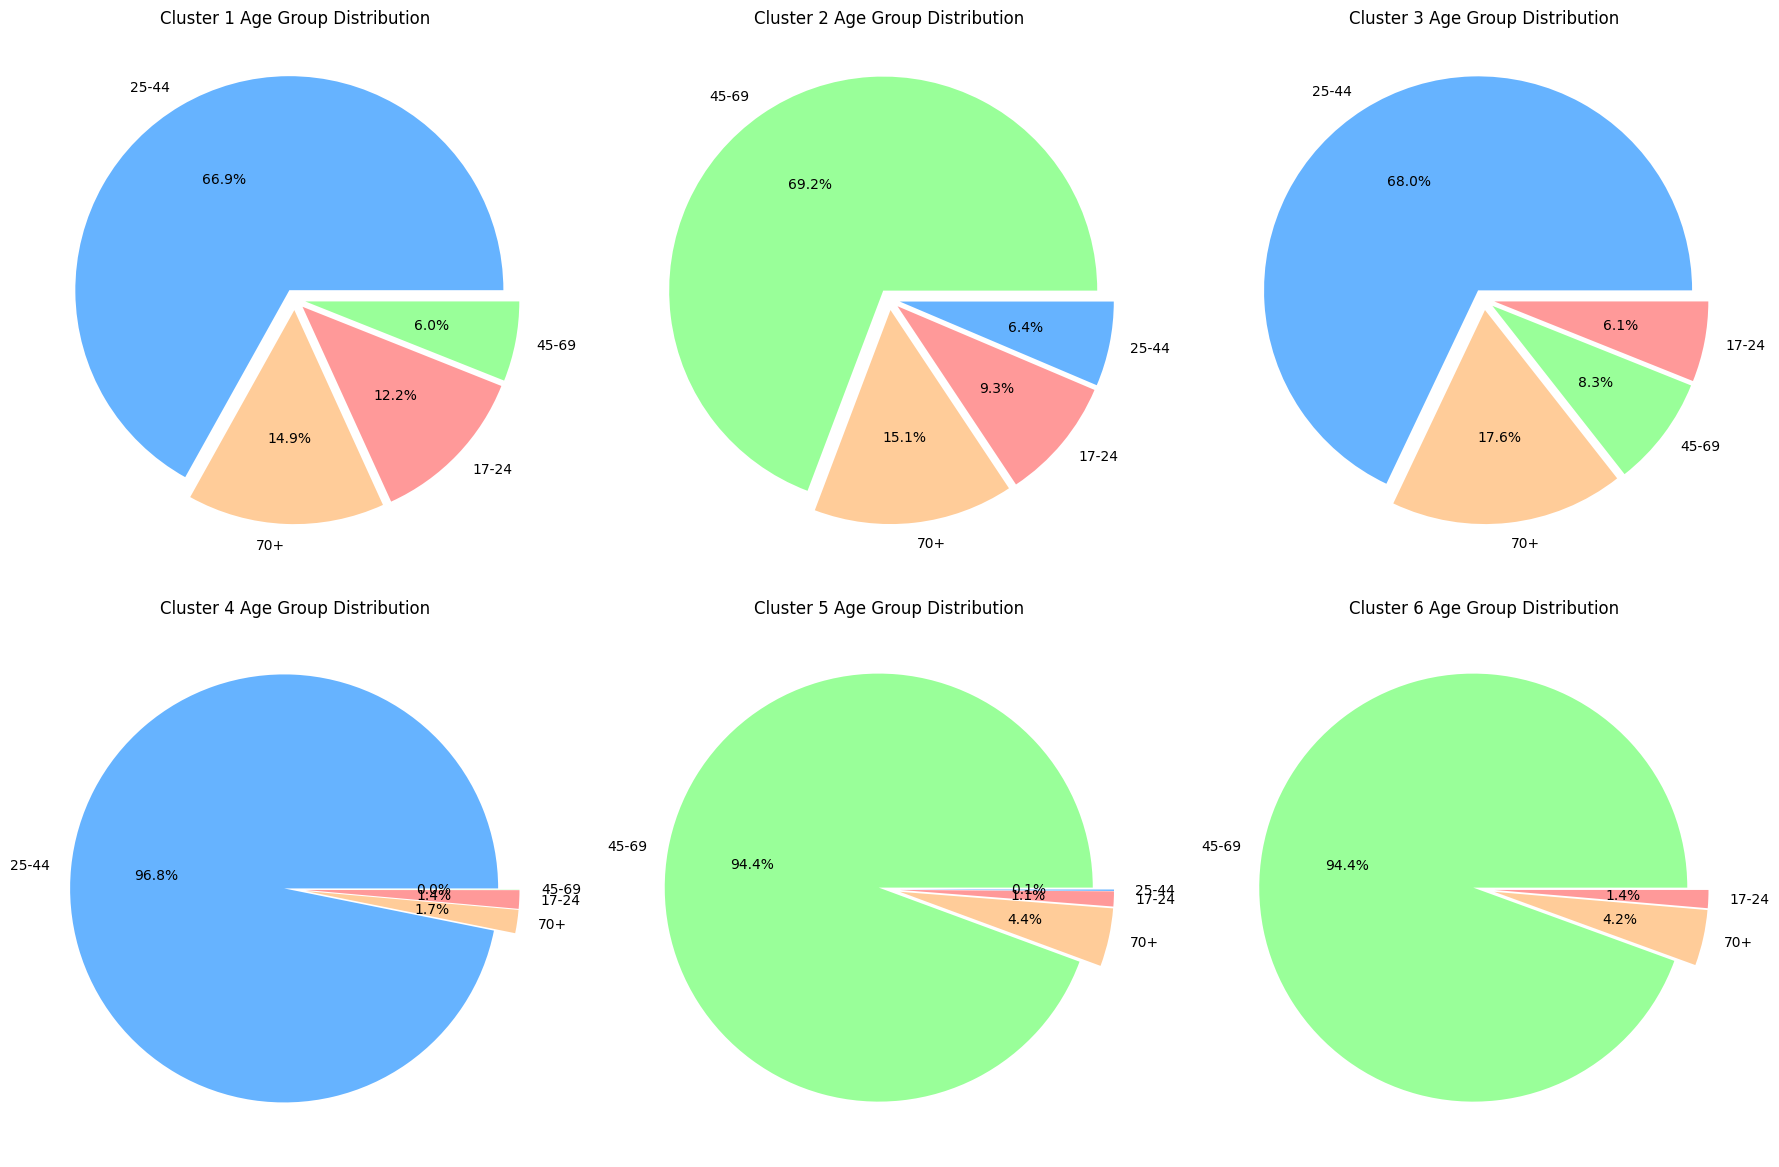

In [ ]:
# Visualizing the distribution of age groups for each cluster

# Define a color map for age groups
age_group_colors = {
    '17-24': '#ff9999',  # light red
    '25-44': '#66b3ff',  # light blue
    '45-69': '#99ff99',  # light green
    '70+': '#ffcc99'     # light orange
}

# Number of clusters
num_clusters = 6

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot each cluster's age_group distribution
for i in range(num_clusters):
    cluster_label = f"Cluster {i + 1}"

    # Filter the dataframe for the current cluster
    cluster_data = df_sampled[df_sampled['cluster'] == cluster_label]

    # Count the occurrences of each age_group in the current cluster
    age_group_counts = cluster_data['age group'].value_counts()

    # Determine the position of the subplot
    row = i // 3
    col = i % 3

    # Determine explode values to separate slices slightly
    explode = [0.05] * len(age_group_counts)

    # Plot the pie chart in the appropriate subplot
    colors = [age_group_colors[age] for age in age_group_counts.index]
    wedges, texts, autotexts = axes[row, col].pie(
        age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%',
        colors=colors, explode=explode, textprops=dict(color="black")  # Changed text color to black
    )

    # Adjust the font size of the labels and percentages
    for text in texts + autotexts:
        text.set_fontsize(10)

    axes[row, col].set_title(f'{cluster_label} Age Group Distribution')

plt.tight_layout()
plt.show()


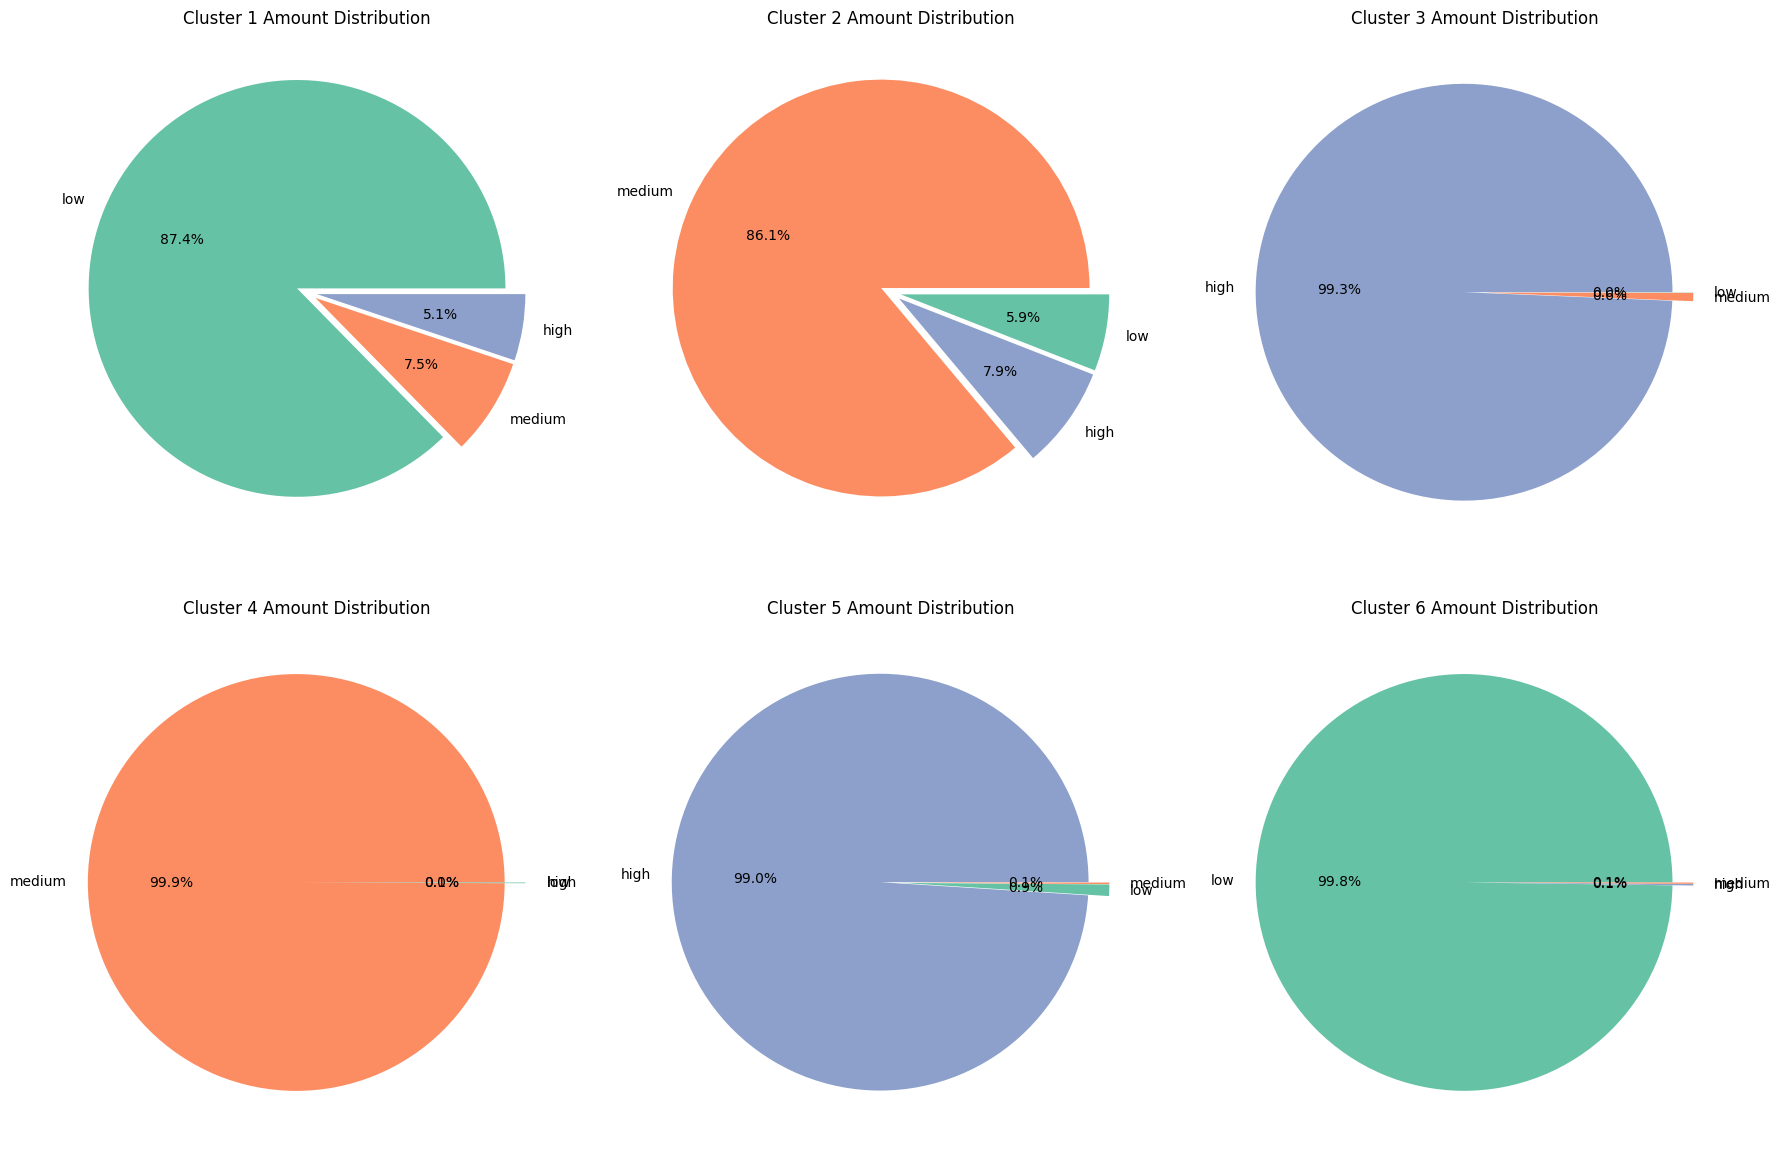

In [ ]:
# Visualizing the distribution of amount bins for each cluster

# Define a color map for amount_bin values
amount_bin_colors = {
    'low': '#66c2a5',    # green
    'medium': '#fc8d62', # orange
    'high': '#8da0cb'    # blue
}

# Number of clusters
num_clusters = 6

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot each cluster's amount_bin distribution
for i in range(num_clusters):
    cluster_label = f"Cluster {i + 1}"

    # Filter the dataframe for the current cluster
    cluster_data = df_sampled[df_sampled['cluster'] == cluster_label]

    # Count the occurrences of each amount_bin in the current cluster
    amount_bin_counts = cluster_data['amount_bin'].value_counts()

    # Determine the position of the subplot
    row = i // 3
    col = i % 3

    # Determine explode values to separate slices slightly
    explode = [0.05] * len(amount_bin_counts)

    # Plot the pie chart in the appropriate subplot
    colors = [amount_bin_colors[bin] for bin in amount_bin_counts.index]
    wedges, texts, autotexts = axes[row, col].pie(
        amount_bin_counts, labels=[label.replace('bin', '') for label in amount_bin_counts.index], autopct='%1.1f%%',
        colors=colors, explode=explode, textprops=dict(color="black")  # Changed text color to black
    )

    # Adjust the font size of the labels and percentages
    for text in texts + autotexts:
        text.set_fontsize(10)

    axes[row, col].set_title(f'{cluster_label} Amount Distribution')

plt.tight_layout()
plt.show()


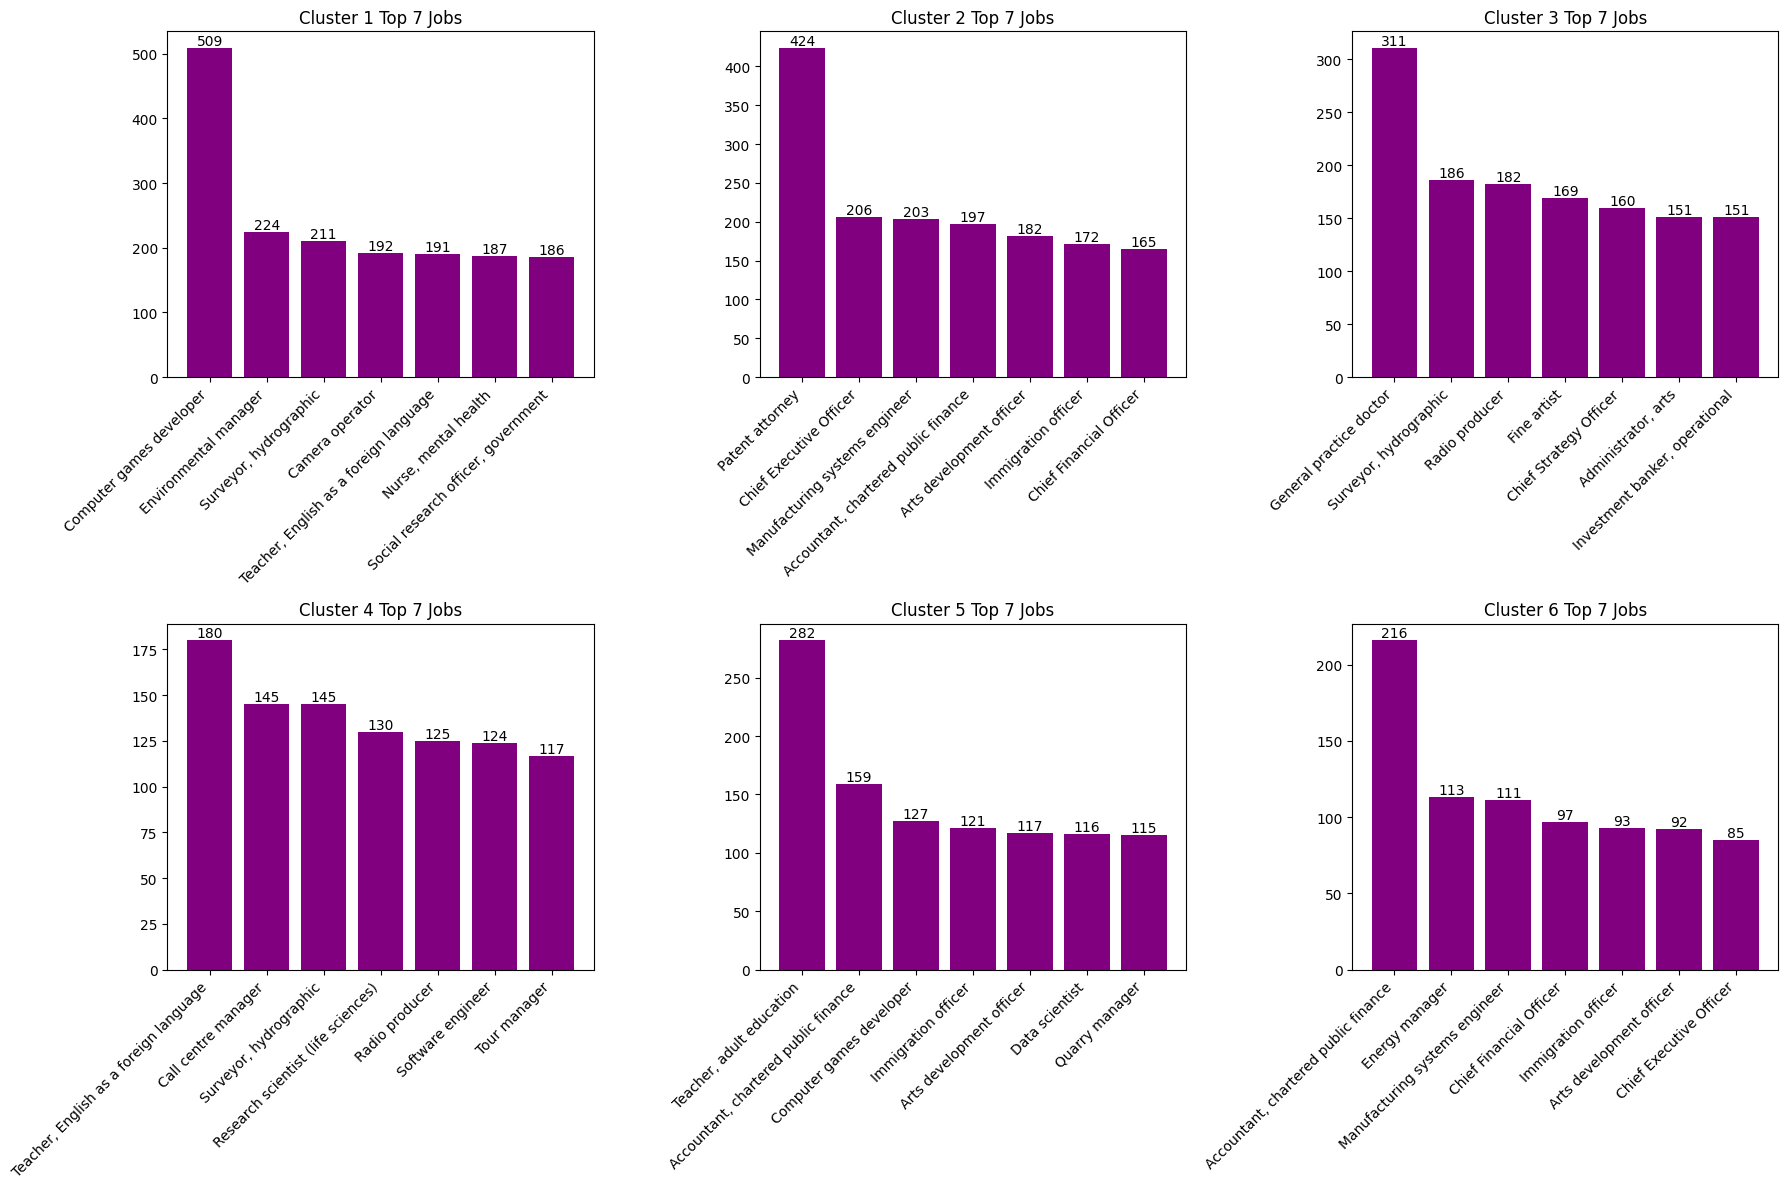

In [ ]:
# Visualizing the top 7 jobs dominated in each cluster

# Number of clusters
num_clusters = 6

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot top 7 job counts for each cluster
for i in range(num_clusters):
    cluster_label = f"Cluster {i + 1}"

    # Filter the dataframe for the current cluster
    cluster_data = df_sampled[df_sampled['cluster'] == cluster_label]

    # Count the occurrences of each job in the current cluster and get top 7
    top_jobs = cluster_data['job'].value_counts().nlargest(7)

    # Determine the position of the subplot
    row = i // 3
    col = i % 3

    # Plot the bar chart in the appropriate subplot
    bars = axes[row, col].bar(top_jobs.index, top_jobs.values, color='purple')
    axes[row, col].set_title(f'{cluster_label} Top 7 Jobs')
    axes[row, col].tick_params(axis='x', rotation=45, labelsize=10)  # Increased font size of x-axis labels

    # Remove grid lines
    axes[row, col].grid(False)

    # Align the x-axis labels under the bars
    axes[row, col].set_xticks(range(len(top_jobs.index)))
    axes[row, col].set_xticklabels(top_jobs.index, ha='right')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


plt.tight_layout()
plt.show()


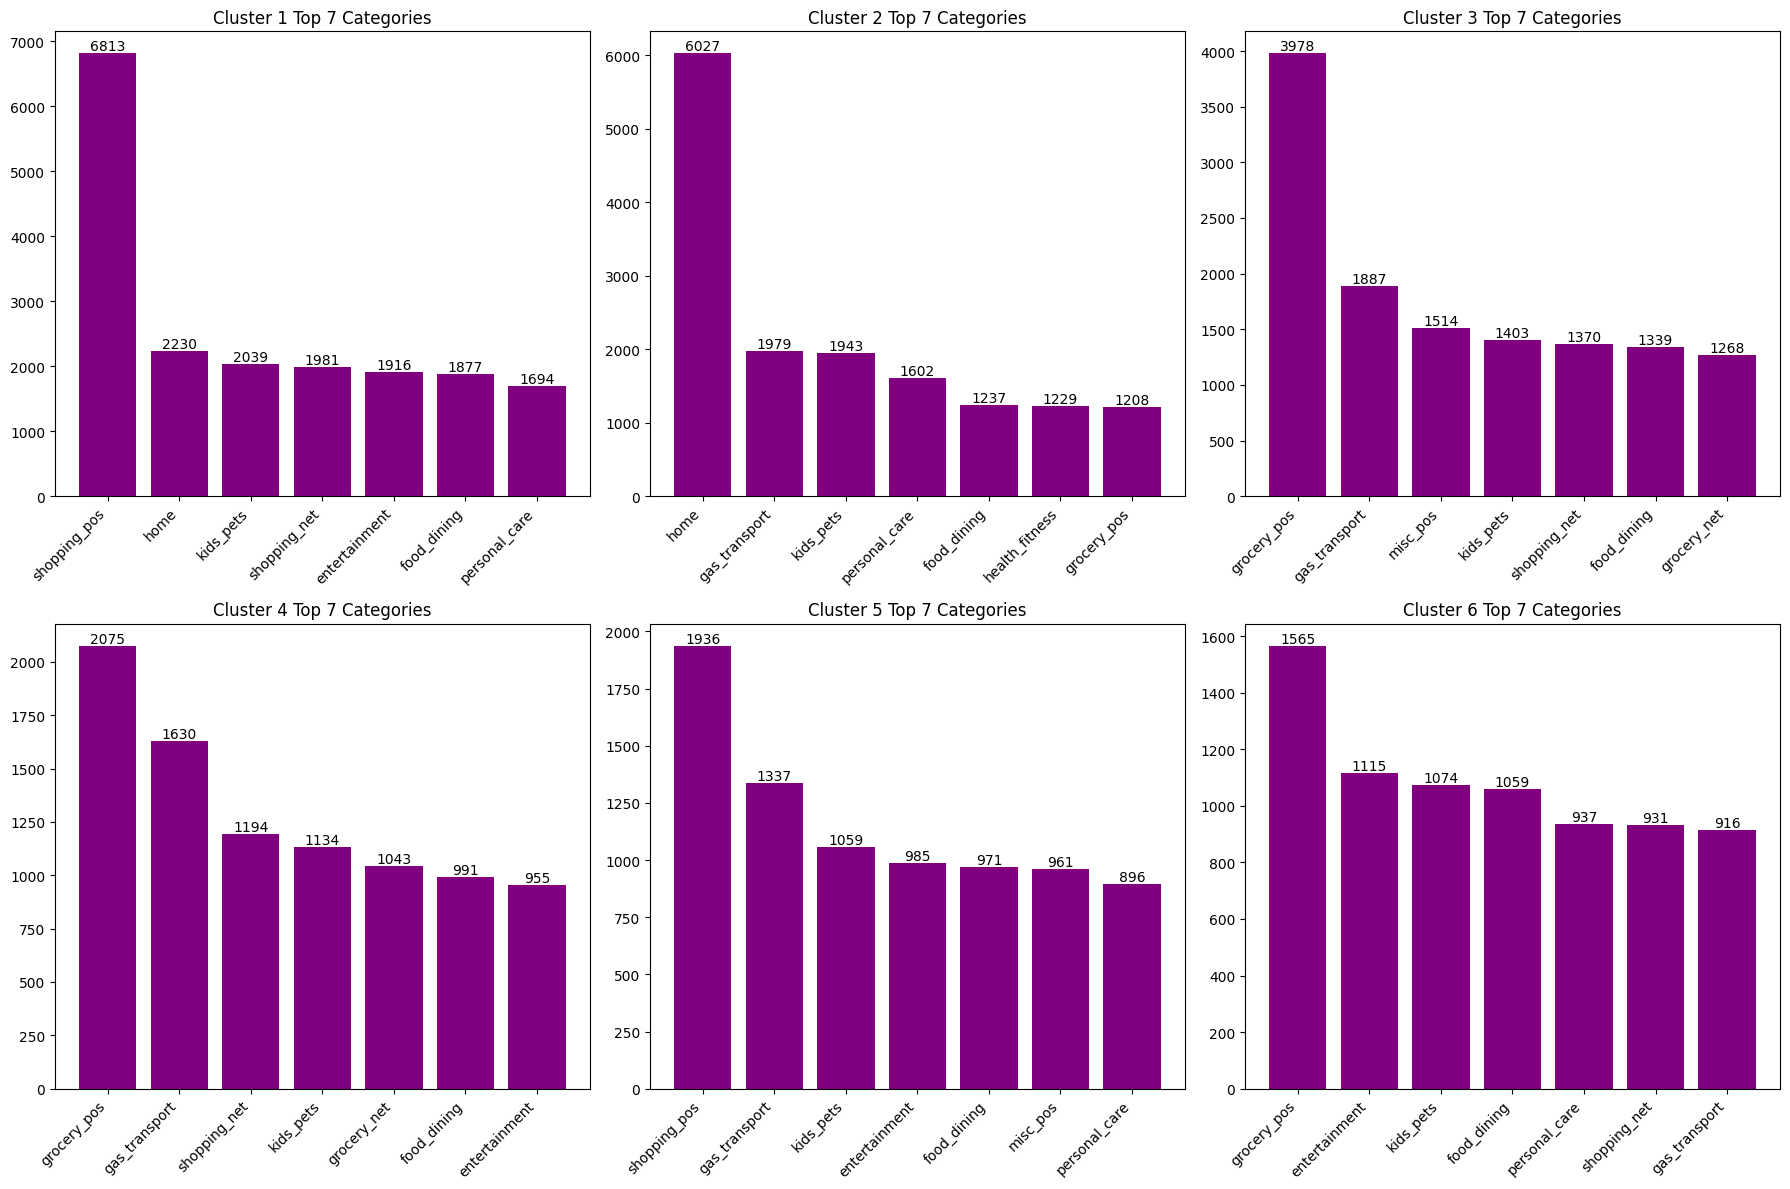

In [ ]:
# Visualizing the top 7 categories dominated in each cluster

# Number of clusters
num_clusters = 6

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot top categories for each cluster
for i in range(num_clusters):
    cluster_label = f"Cluster {i + 1}"

    # Filter the dataframe for the current cluster
    cluster_data = df_sampled[df_sampled['cluster'] == cluster_label]

    # Count the occurrences of each category in the current cluster and get top 7
    top_categories = cluster_data['category'].value_counts().nlargest(7)

    # Determine the position of the subplot
    row = i // 3
    col = i % 3

    # Plot the bar chart in the appropriate subplot
    bars = axes[row, col].bar(top_categories.index, top_categories.values, color='purple')
    axes[row, col].set_title(f'{cluster_label} Top 7 Categories')
    axes[row, col].tick_params(axis='x', rotation=45, labelsize=10)  # Increased font size of x-axis labels

    # Remove grid lines
    axes[row, col].grid(False)

    # Align the x-axis labels under the bars
    axes[row, col].set_xticks(range(len(top_categories.index)))
    axes[row, col].set_xticklabels(top_categories.index, ha='right')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


plt.tight_layout()
plt.show()


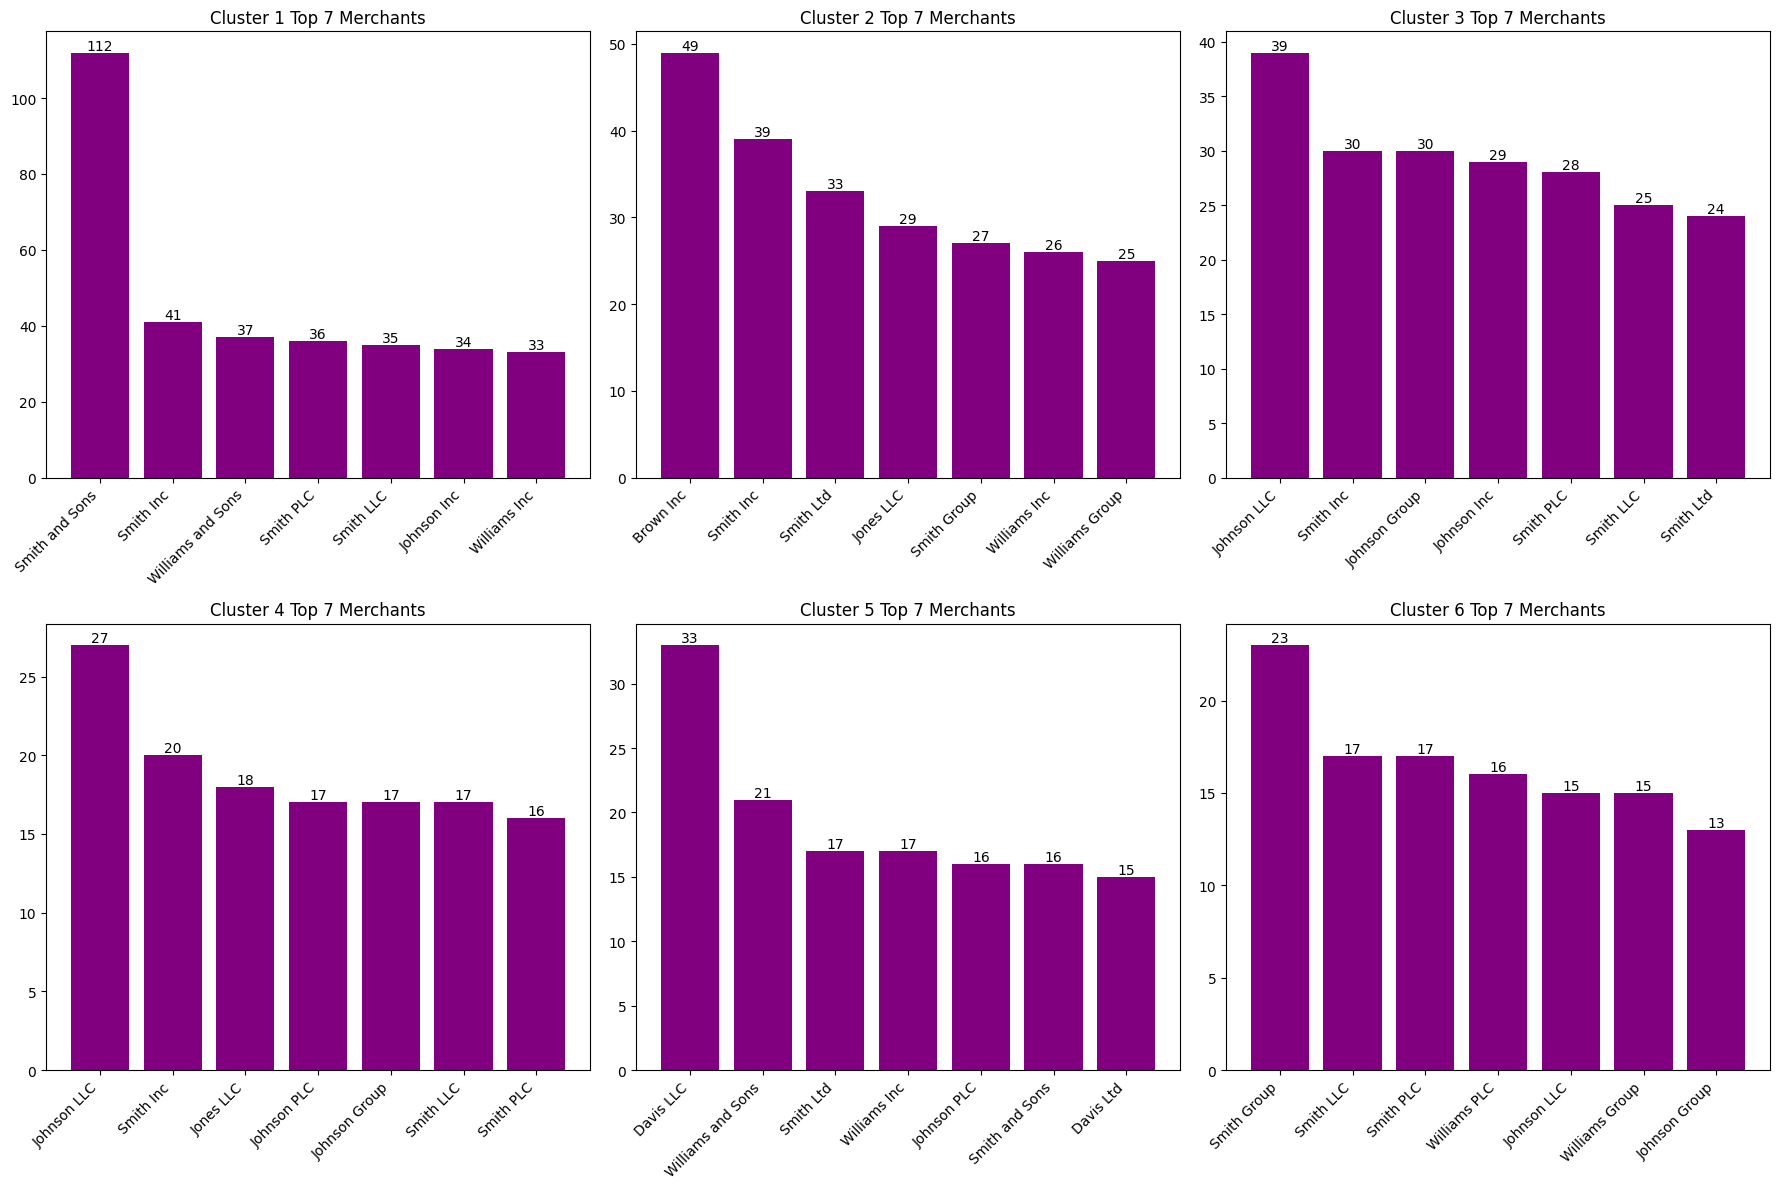

In [ ]:
# Visualizing the top 7 merchants dominated in each cluster

# Number of clusters
num_clusters = 6

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot top merchants for each cluster
for i in range(num_clusters):
    cluster_label = f"Cluster {i + 1}"

    # Filter the dataframe for the current cluster
    cluster_data = df_sampled[df_sampled['cluster'] == cluster_label]

    # Count the occurrences of each merchant in the current cluster and get top 7
    top_merchants = cluster_data['merchant'].value_counts().nlargest(7)

    # Determine the position of the subplot
    row = i // 3
    col = i % 3

    # Plot the bar chart in the appropriate subplot
    bars = axes[row, col].bar(top_merchants.index, top_merchants.values, color='purple')
    axes[row, col].set_title(f'{cluster_label} Top 7 Merchants')
    axes[row, col].tick_params(axis='x', rotation=45, labelsize=10)  # Increased font size of x-axis labels

    # Remove grid lines
    axes[row, col].grid(False)

    # Align the x-axis labels under the bars
    axes[row, col].set_xticks(range(len(top_merchants.index)))
    axes[row, col].set_xticklabels(top_merchants.index, ha='right')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')


plt.tight_layout()
plt.show()
